In [2]:
%matplotlib inline

In [151]:
from thllib import flylib as flb
import numpy as np
import scipy
from thllib import util
import scipy.signal
import sys

FLYNUM = 1397#int(sys.argv[1])# tested with 1393
RESAMPLE_RATE = 2000 #hz
TAU_ON = 0.01595905
TAU_OFF = 0.23594343
KERNEL_GAIN = 0.4
SNR = 2.0
DEFALULT_ISI = 0.005 #s
MAX_ISI_TIME = 0.02

fly = flb.NetFly(FLYNUM,rootpath='/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

def condition_signal(sig_name,signal):
    """do some data cleaning on the signals.
    For instnace the transients from b2 are week
    so I need to detrend in order to remove the
    contaminating baseline"""
    if sig_name == 'b2':
        return signal - scipy.signal.medfilt(signal,501)
    if sig_name == 'iii1':
        return signal - scipy.signal.medfilt(signal,501)
    if sig_name == 'hg1':
        return signal - scipy.signal.medfilt(signal,501)
    return signal

def wiener_deconvolution(signal, kernel, snr):
    "lambd is the SNR"
    from scipy import fft,ifft
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + snr**2)))
    return deconvolved

def make_single_kernel(times,tauon1,tauoff1):
    kx = np.copy(times)
    kon1 = lambda x:np.exp(((-1*tauon1)/(x)))
    koff1 = lambda x:np.exp((-1*x)/tauoff1)
    k1 = (kon1(kx)*koff1(kx))
    return k1/np.max(k1)

def get_potential_idxs(resampled_freq,resampled_t):
    potential_impulse_idxs = list()
    spike_idx = 1
    spike_time = resampled_t[spike_idx]
    while(spike_time<resampled_t[-1]):
        spike_idx = np.searchsorted(resampled_t,spike_time)
        potential_impulse_idxs.append(spike_idx)
        isi = 1./resampled_freq[spike_idx]
        if (abs(isi) < MAX_ISI_TIME):
            spike_time += isi[0]
        else:
            spike_time += DEFALULT_ISI
    return potential_impulse_idxs

print('resampling')
resampled_left = {}
for key,value in fly.ca_cam_left_model_fits.items():
    value = condition_signal(key,value)
    resampled_ca,resampled_t = scipy.signal.resample(value,
                                           int(fly.time[-1]*RESAMPLE_RATE),np.array(fly.time),
                                            window = 'hanning')
    resampled_left[key] = resampled_ca

resampled_right = {}
for key,value in fly.ca_cam_right_model_fits.items():
    value = condition_signal(key,value)
    resampled_ca,resampled_t = scipy.signal.resample(value,
                                           int(fly.time[-1]*RESAMPLE_RATE),np.array(fly.time),
                                            window = 'hanning')
    resampled_right[key] = resampled_ca
    
resampled_freq,resampled_t = scipy.signal.resample(fly.wb_freq,
                                 int(fly.time[-1]*RESAMPLE_RATE),
                                 np.array(fly.time),
                                 window = 'hanning')

print('using wb_frequency to make a list of potential spike times')
potential_impulse_idxs = list()
spike_idx = 1
spike_time = resampled_t[spike_idx]

################################
# Identify the putative spikes #
################################


potential_impulse_idxs = get_potential_idxs(resampled_freq,resampled_t)

kernel = make_single_kernel(resampled_t,TAU_ON,TAU_OFF)

print('wiener_deconvolution')
################################
# Deconvolve                   #
################################
decon_left = {}
for key,value in resampled_left.items():
    #print key
    decon = wiener_deconvolution(value,kernel[:5000]*KERNEL_GAIN,SNR)
    decon_left[key] = decon

decon_right = {}
for key,value in resampled_right.items():
    #print key
    decon = wiener_deconvolution(value,kernel[:5000]*KERNEL_GAIN,SNR)
    decon_right[key] = decon

################################
# Decide if a spike was fired  #
################################
print('setting spikes')
spikes_left = {}
for key,value in decon_left.items():
    #print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_left[key])[0][1],
                           impulses,
                           recon))
    spikes_left[key] = threshlist
    
spikes_right = {}
for key,value in decon_right.items():
    #print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_right[key])[0][1],
                          impulses,
                          recon))
    spikes_right[key] = threshlist

################################
# Pick the best threshold      #
################################
print('picking thresh')
best_spikes = {}
for key,value in spikes_left.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['left',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}
for key,value in spikes_right.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['right',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}

print('downsampling and saving data')
potential_impulse_times = resampled_t[potential_impulse_idxs]
for key in best_spikes:    
    spike_sig = best_spikes[key]['spikes']
    recon_sig = best_spikes[key]['reconstruction']
    state_save = np.zeros_like(fly.time)
    recon_save = np.zeros_like(fly.time)
    for i,timetup in enumerate(zip(fly.time[:-1],fly.time[1:])):
        t1,t2 = timetup
        idx1 = np.searchsorted(potential_impulse_times,t1)
        idx2 = np.searchsorted(potential_impulse_times,t2)
        state_save[i] = np.sum(spike_sig[potential_impulse_idxs[idx1:idx2]]/(idx2-idx1))>0.5
        r_idx1 = np.searchsorted(resampled_t,t1)
        r_idx2 = np.searchsorted(resampled_t,t2)
        recon_save[i] = np.mean(recon_sig[r_idx1:r_idx2])
    fly.save_hdf5(state_save,'spikestate_%s_%s'%key, overwrite = True)
    fly.save_hdf5(recon_save,'reconstruct_%s_%s'%key, overwrite = True)

resampling
using wb_frequency to make a list of potential spike times


/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide


wiener_deconvolution
setting spikes
picking thresh
downsampling and saving data


In [167]:
potential_impulse_times = resampled_t[potential_impulse_idxs]

state_dict = {}
reconstruct_dict = {}

for key in best_spikes:    
    spike_sig = best_spikes[key]['spikes']
    recon_sig = best_spikes[key]['reconstruction']
    state_save = np.zeros_like(fly.time)
    recon_save = np.zeros_like(fly.time)
    for i,timetup in enumerate(zip(fly.time[:-1],fly.time[1:])):
        t1,t2 = timetup
        idx1 = np.searchsorted(potential_impulse_times,t1)
        idx2 = np.searchsorted(potential_impulse_times,t2)
        state_save[i] = np.sum(spike_sig[potential_impulse_idxs[idx1:idx2]]/(idx2-idx1))>0.5
        r_idx1 = np.searchsorted(resampled_t,t1)
        r_idx2 = np.searchsorted(resampled_t,t2)
        recon_save[i] = np.mean(recon_sig[r_idx1:r_idx2])
    state_dict[key] = state_save
    reconstruct_dict[key] = recon_save

fly.save_pickle(state_dict,'spikestates')
fly.save_pickle(reconstruct_dict,'ca_reconstructions')
    #fly.save_hdf5(state_save,'spikestate_%s_%s'%key, overwrite = True)
    #fly.save_hdf5(recon_save,'reconstruct_%s_%s'%key, overwrite = True)

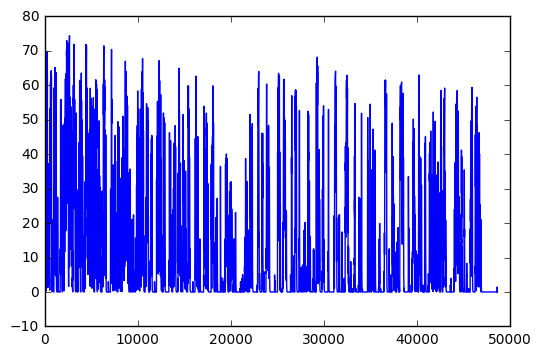

In [171]:
plt.plot(fly.ca_reconstructions['left','i1'])

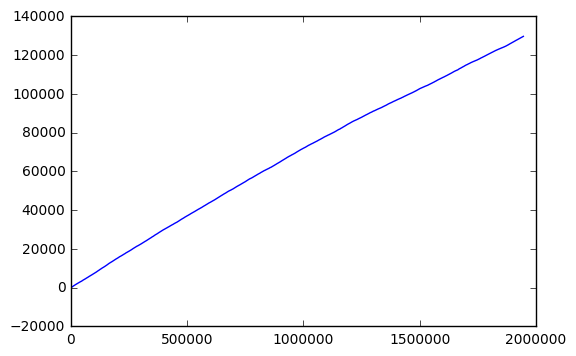

In [76]:
plt.plot(spikes_left['iii3'][4][2])

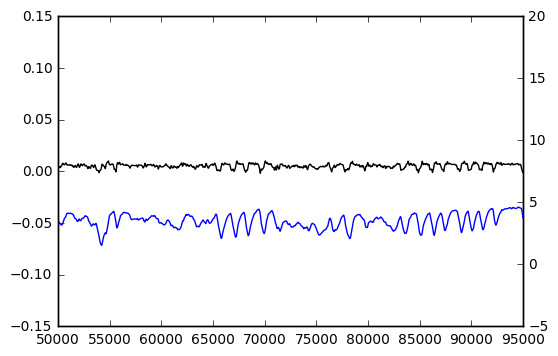

In [161]:
plt.plot(wiener_deconvolution(resampled_right['iii3'],kernel*1.0,20.0),color = 'k')
plt.twinx()
plt.plot(resampled_right['iii3'])
plt.gca().set_xbound(50000,95000)

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide


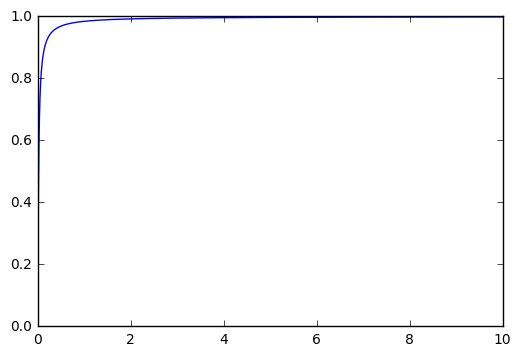

In [150]:
kernel = make_single_kernel(resampled_t,TAU_ON,TAU_OFF)
plt.plot(resampled_t,kernel)
plt.gca().set_xbound(0,10)